# I’m Something of a Painter Myself
## Problem Description
The competition focuses on leveraging Generative Adversarial Networks (GANs) to translate real-world landscape photographs into paintings that mimic the style of Claude Monet. Image-to-image translation using GANs has become a powerful tool for artistic applications, enabling the creation of visually compelling outputs without requiring paired datasets.

In this challenge, participants are provided with a collection of Monet paintings and real photographs. The objective is to train a model that can learn Monet’s unique painting style and apply it to unseen photographs. The competition evaluates the generated images using the Memorization-informed Fréchet Inception Distance (MiFID), a metric that rewards high-quality, creative images while penalizing overfitting and memorization.

This project introduces the challenge of style transfer using unpaired data, requiring the model to not only capture Monet's artistic characteristics but also generalize the style across diverse real-world scenes.


## Dataset Description
The dataset contains four directories: `monet_tfrec`, `photo_tfrec`, `monet_jpg`, and `photo_jpg`. The `monet_tfrec` and `monet_jpg` directories contain the same Monet paintings, and the `photo_tfrec` and `photo_jpg` directories contain the same landscape photos.

While TFRecord files are provided for more advanced use, JPEG images are also available for convenience. For this project, we will primarily work with JPEG files for easier data loading and visualization.

- The `monet_jpg` directory contains Monet paintings. These images will be used to train the model to learn Monet's painting style.
- The `photo_jpg` directory contains real-world landscape photographs. The model will be trained to translate these photos into Monet-style paintings.
- The `test_photo_jpg` directory contains unseen real-world photos on which we must apply the trained model for the final submission.

# Step 1 Exploratory Data Analysis (EDA)

In this section, I perform a basic visual exploration of the two main datasets: `monet_jpg` and `photo_jpg`. This helps us understand the visual differences between Monet-style paintings and real-life landscape photos.

Claude Monet’s paintings are characterized by soft brushstrokes, pastel color tones, and impressionistic depictions of light and nature. In contrast, the real-world photographs are sharp, detailed, and capture objective scenes with natural lighting and texture.

By visualizing a few images from each dataset, we can build an intuition for what kind of transformation our model will need to learn.


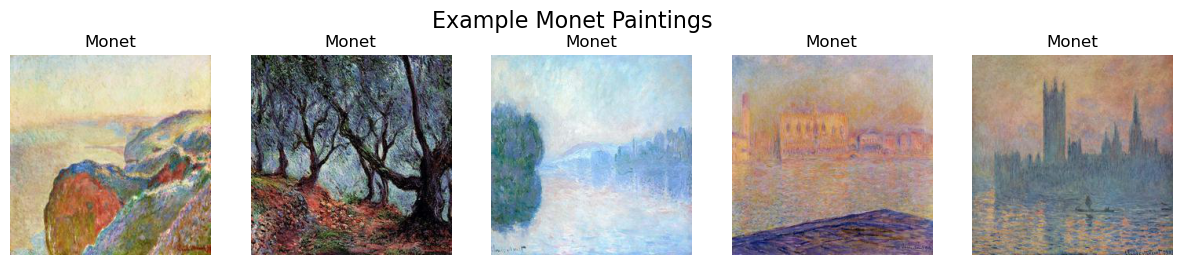

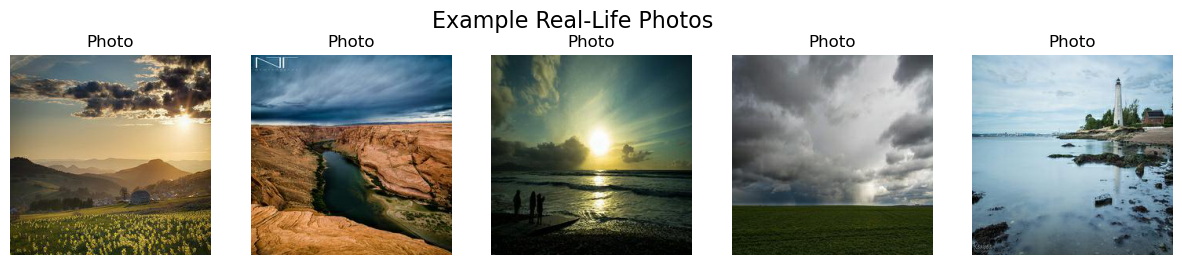

In [1]:
import os
import matplotlib.pyplot as plt 
from PIL import Image
# Set paths
monet_dir = "monet_jpg"
photo_dir = "photo_jpg"

# Get the first 5 images from each folder
monet_images = sorted(os.listdir(monet_dir))[:5]
photo_images = sorted(os.listdir(photo_dir))[:5]

# Plot Monet-style paintings
plt.figure(figsize = (15,3))
for i,img_name in enumerate(monet_images):
    img = Image.open(os.path.join(monet_dir,img_name))
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Monet')
plt.suptitle("Example Monet Paintings", fontsize=16)
plt.show()
    
# Plot real-world photos
plt.figure(figsize = (15,3))
for i, img_name in enumerate(photo_images):
    img = Image.open(os.path.join(photo_dir, img_name))
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Photo")

plt.suptitle("Example Real-Life Photos", fontsize=16)
plt.show()

From the visualization above, we can make several key observations:

 **Monet Paintings**:
  - The paintings display a distinct impressionistic style, characterized by visible brushstrokes and soft, blended color palettes.
  - Color schemes are often pastel and muted, with a focus on atmospheric effects rather than fine-grained detail.
  - Many scenes depict nature, bodies of water, landscapes, and cityscapes under varying lighting conditions, often with an emphasis on capturing mood and ambiance rather than photorealism.

 **Real-Life Photos**:
  - The photos are highly detailed with clear edges and sharp contrasts.
  - Natural color distributions are dominant, especially vivid blues, greens, browns, and highlights from sunlight.
  - Images often contain crisp depictions of landscapes, seascapes, urban skylines, and weather patterns, reflecting real-world clarity and structure.


# Step 2 Dataset Preparation 

## 2.1

In [6]:
from torch.utils.data import Dataset
from torchvision import transforms

class MonetPhotoDataset(Dataset):
    def __init__(self, root_monet, root_photo, transform=None, mode="train"):  
        self.root_monet = root_monet
        self.root_photo = root_photo
        self.transform = transform
        self.mode = mode

        # Load all image filenames from each folder
        self.monet_images = os.listdir(root_monet)
        self.photo_images = os.listdir(root_photo)

    def __len__(self):
        # Return the smaller dataset length to avoid IndexError
        return min(len(self.monet_images), len(self.photo_images))

    def __getitem__(self, index):
        # Get image paths with modulo to allow cycling over smaller dataset
        monet_path = os.path.join(self.root_monet, self.monet_images[index % len(self.monet_images)])
        photo_path = os.path.join(self.root_photo, self.photo_images[index % len(self.photo_images)])

        monet_img = Image.open(monet_path).convert("RGB")
        photo_img = Image.open(photo_path).convert("RGB")

        # Apply transform if specified
        if self.transform:
            monet_img = self.transform(monet_img)
            photo_img = self.transform(photo_img)

        return {"monet": monet_img, "photo": photo_img}

This dataset class is used to load and return paired Monet-style and real-world images.
It prepares data for training a CycleGAN by applying consistent transforms and ensuring image batches are returned in dictionary format with "monet" and "photo" keys.

## 2.2 Configure Image Transformations (Resize + ToTensor + Normalize)

In [10]:
from torchvision import transforms

# Transformation pipeline for preprocessing input images
transform_pipeline = transforms.Compose([
    transforms.Resize((256, 256)),     # Resize all images to 256x256
    transforms.ToTensor(),             # Convert image to [0,1] tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])


Before feeding images into the model, we apply a sequence of transformations to ensure consistency in size and value distribution. This step prepares the data for training by resizing, converting to tensor format, and normalizing the pixel values.

- `Resize(256, 256)`: Ensures all input images are the same size (256x256 pixels).
- `ToTensor()`: Converts the image from a PIL format to a PyTorch tensor with values in [0, 1].
- `Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`: Normalizes each RGB channel to the range [-1, 1], which is standard for GAN training.

This normalization helps the model converge faster and ensures that the generator and discriminator receive inputs in a consistent format.

## 2.3 Creating DataLoader

In [16]:
from torch.utils.data import DataLoader

# Set relative paths 
monet_dir = "monet_jpg"
photo_dir = "photo_jpg"

# Initialize the custom Dataset
dataset = MonetPhotoDataset(root_monet=monet_dir, root_photo=photo_dir, transform=transform_pipeline)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

# Check one batch
batch = next(iter(dataloader))
print(batch["monet"].shape)  # torch.Size([16, 3, 256, 256])
print(batch["photo"].shape)  # torch.Size([16, 3, 256, 256])


torch.Size([16, 3, 256, 256])
torch.Size([16, 3, 256, 256])


In this step, we wrap our custom `MonetPhotoDataset` with PyTorch's `DataLoader` to enable:

**Batch loading**: Efficient training with multiple images at once.
**Shuffling**: Better model generalization by randomizing image order.
**Parallel loading**: Faster data loading using multiple workers.

We redefine `monet_dir` and `photo_dir` here to ensure clarity and standalone functionality for this block. Even though these paths were set earlier in the EDA section, it's common practice to redefine them for modular code readability.

Finally, we verify the shape of one batch to confirm that images are correctly loaded and preprocessed.

# Step 3 Model Architecture (CycleGAN)  

## 3.1 Generator: ResNet-based

The generator in CycleGAN is based on a ResNet architecture.
It transforms an image from one domain (e.g., photo) into another (e.g., Monet) using convolutional layers, residual blocks, and transposed convolutions for upsampling.

In [22]:
import torch
import torch.nn as nn

# Residual Block
class ResNetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0),
            nn.InstanceNorm2d(dim),
        )

    def forward(self, x):
        return x + self.block(x)  # Skip connection

# Generator: ResNet-based architecture
class ResNetGenerator(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, num_filters=64, num_blocks=6):
        super().__init__()

        # Initial convolution
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, num_filters, kernel_size=7, padding=0),
            nn.InstanceNorm2d(num_filters),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        in_features = num_filters
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(num_blocks):
            model += [ResNetBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_features, output_nc, kernel_size=7, padding=0),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


The generator network takes an image from the input domain (e.g., real photo) and outputs a stylized image (e.g., Monet-style) using a ResNet-based architecture with residual blocks and upsampling.

It consists of:
- Downsampling (2 conv layers)
- Residual blocks (6 or 9 blocks)
- Upsampling (2 transpose conv layers)
- Output layer with `tanh()` to scale pixel values to [-1, 1]

## 3.2 Discriminator Architecture (PatchGAN)

In CycleGAN, we use a PatchGAN discriminator, which classifies image patches (e.g., 70×70) as real or fake instead of the entire image.
This helps the model focus on local texture and style consistency, which is ideal for image translation tasks.

In [27]:
# PatchGAN Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_nc=3, num_filters=64):
        super().__init__()
        model = []

        # No normalization in first layer
        model += [
            nn.Conv2d(input_nc, num_filters, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        ]

        in_features = num_filters
        out_features = in_features * 2

        for _ in range(3):
            model += [
                nn.Conv2d(in_features, out_features, kernel_size=4, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            in_features = out_features
            out_features = min(in_features * 2, 512)  # Cap at 512

        # Final output layer
        model += [
            nn.Conv2d(in_features, 1, kernel_size=4, padding=1)
            # No activation here — we'll apply BCEWithLogitsLoss later
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


CycleGAN uses a PatchGAN discriminator that classifies small image patches (e.g., 70×70) instead of the entire image.

This architecture encourages the generator to produce more realistic local textures and fine-grained details, which is important for style transfer.

The discriminator consists of:
- 4 convolutional layers with increasing filters
- LeakyReLU activations and InstanceNorm
- No sigmoid at the end (we use `BCEWithLogitsLoss` during training)


## 3.3 Loss Fuction + CycleGAN

In [31]:
# Adversarial loss: standard GAN loss with logits
adv_criterion = nn.BCEWithLogitsLoss()

# Cycle consistency loss: L1 loss between original and reconstructed image
cycle_criterion = nn.L1Loss()

# Identity loss: L1 loss between input and output when domains match
identity_criterion = nn.L1Loss()


In CycleGAN, training relies on three key loss components:

- **Adversarial loss** helps the generator produce images that are indistinguishable from real ones by the discriminator.
- **Cycle consistency loss** ensures that if we translate an image to another domain and back, we get the original image.
- **Identity loss** (optional) stabilizes training and helps preserve colors and content when the input is already similar to the target domain.

These losses are combined with appropriate weights (typically λ=10 for cycle loss, λ=5 for identity loss) to guide the generator toward producing realistic and semantically consistent images.

## 3.4 Model Integration – CycleGAN Wrapper

In [41]:
# Initialize model components
G_A2B = ResNetGenerator(input_nc=3, output_nc=3)  # Generator: Photo → Monet
G_B2A = ResNetGenerator(input_nc=3, output_nc=3)  # Generator: Monet → Photo
D_A = Discriminator(input_nc=3)  # Discriminator for real photos
D_B = Discriminator(input_nc=3)  # Discriminator for real Monet paintings

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define CycleGAN wrapper class
class CycleGANModel:
    def __init__(self, G_A2B, G_B2A, D_A, D_B, device):
        """
        G_A2B: Generator A → B (e.g. Photo → Monet)
        G_B2A: Generator B → A (e.g. Monet → Photo)
        D_A: Discriminator for domain A (e.g. Photo)
        D_B: Discriminator for domain B (e.g. Monet)
        """
        self.device = device

        # Move models to device
        self.G_A2B = G_A2B.to(device)
        self.G_B2A = G_B2A.to(device)
        self.D_A = D_A.to(device)
        self.D_B = D_B.to(device)

        # Loss functions
        self.adv_loss = nn.BCEWithLogitsLoss()
        self.cycle_loss = nn.L1Loss()
        self.identity_loss = nn.L1Loss()

        # Loss weights
        self.lambda_cycle = 10.0
        self.lambda_identity = 5.0

    def set_input(self, real_A, real_B):
        """
        real_A: real photos
        real_B: real Monet images
        """
        self.real_A = real_A.to(self.device)
        self.real_B = real_B.to(self.device)

    def forward_generators(self):
        self.fake_B = self.G_A2B(self.real_A)
        self.rec_A = self.G_B2A(self.fake_B)
        self.fake_A = self.G_B2A(self.real_B)
        self.rec_B = self.G_A2B(self.fake_A)

    def compute_generator_loss(self):
        # Adversarial loss
        pred_fake_B = self.D_B(self.fake_B)
        pred_fake_A = self.D_A(self.fake_A)
        loss_GAN_A2B = self.adv_loss(pred_fake_B, torch.ones_like(pred_fake_B))
        loss_GAN_B2A = self.adv_loss(pred_fake_A, torch.ones_like(pred_fake_A))

        # Cycle consistency
        loss_cycle_A = self.cycle_loss(self.rec_A, self.real_A)
        loss_cycle_B = self.cycle_loss(self.rec_B, self.real_B)

        # Identity loss
        idt_B = self.G_A2B(self.real_B)
        idt_A = self.G_B2A(self.real_A)
        loss_idt_A = self.identity_loss(idt_A, self.real_A)
        loss_idt_B = self.identity_loss(idt_B, self.real_B)

        # Total generator loss
        total_loss = (
            loss_GAN_A2B + loss_GAN_B2A +
            self.lambda_cycle * (loss_cycle_A + loss_cycle_B) +
            self.lambda_identity * (loss_idt_A + loss_idt_B)
        )
        return total_loss

    def compute_discriminator_loss(self, D, real, fake):
        pred_real = D(real)
        pred_fake = D(fake.detach())
        loss_real = self.adv_loss(pred_real, torch.ones_like(pred_real))
        loss_fake = self.adv_loss(pred_fake, torch.zeros_like(pred_fake))
        return (loss_real + loss_fake) * 0.5


This class integrates all components of CycleGAN, including:

- Two generators (A→B and B→A)
- Two discriminators
- Loss functions and hyperparameters

It handles:
- Forward passes for both domains
- Cycle and identity loss computation
- Adversarial loss for both generators and discriminators

This modular setup keeps the training loop clean and allows easy extension or logging.


## Step 4 Training Process

In [47]:
import torch.optim as optim
from tqdm import tqdm

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
cycle_gan = CycleGANModel(G_A2B, G_B2A, D_A, D_B, device)

# Define optimizers
optimizer_G = optim.Adam(
    list(cycle_gan.G_A2B.parameters()) + list(cycle_gan.G_B2A.parameters()),
    lr=2e-4, betas=(0.5, 0.999)
)
optimizer_D_A = optim.Adam(cycle_gan.D_A.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(cycle_gan.D_B.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for i, batch in enumerate(tqdm(dataloader)):
        real_A = batch["photo"]
        real_B = batch["monet"]

        ### -------- Train Generators --------
        cycle_gan.set_input(real_A, real_B)
        cycle_gan.forward_generators()

        loss_G = cycle_gan.compute_generator_loss()

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        ### -------- Train Discriminators --------
        # Train D_A (real vs fake_A)
        loss_D_A = cycle_gan.compute_discriminator_loss(
            cycle_gan.D_A, cycle_gan.real_A, cycle_gan.fake_A
        )
        optimizer_D_A.zero_grad()
        loss_D_A.backward()
        optimizer_D_A.step()

        # Train D_B (real vs fake_B)
        loss_D_B = cycle_gan.compute_discriminator_loss(
            cycle_gan.D_B, cycle_gan.real_B, cycle_gan.fake_B
        )
        optimizer_D_B.zero_grad()
        loss_D_B.backward()
        optimizer_D_B.step()

        if i % 100 == 0:
            print(f"[{i}] Loss_G: {loss_G.item():.4f}, Loss_D_A: {loss_D_A.item():.4f}, Loss_D_B: {loss_D_B.item():.4f}")


Epoch 1/3


  5%|██▎                                        | 1/19 [02:48<50:36, 168.71s/it]

[0] Loss_G: 10.3671, Loss_D_A: 0.6157, Loss_D_B: 0.6168


100%|██████████████████████████████████████████| 19/19 [55:32<00:00, 175.42s/it]


Epoch 2/3


  5%|██▎                                        | 1/19 [02:37<47:22, 157.92s/it]

[0] Loss_G: 10.3871, Loss_D_A: 0.6056, Loss_D_B: 0.6024


100%|██████████████████████████████████████████| 19/19 [54:27<00:00, 172.00s/it]


Epoch 3/3


  5%|██▎                                        | 1/19 [02:35<46:42, 155.69s/it]

[0] Loss_G: 10.0354, Loss_D_A: 0.5919, Loss_D_B: 0.5694


100%|██████████████████████████████████████████| 19/19 [52:20<00:00, 165.32s/it]


I alternate between training:

- The two generators (A→B and B→A) using adversarial, cycle-consistency, and identity losses.
- The two discriminators (D_A and D_B) using standard GAN binary cross-entropy loss.

Adam optimizers with β=(0.5, 0.999) are commonly used in GAN training for stability. Each epoch involves:

- Forward pass and loss computation
- Backward pass and optimizer step


In [59]:
torch.save(G_A2B.state_dict(), "G_A2B.pth")


## Step 5 Inference & Kaggle Submission

In [53]:
import torchvision.transforms as T
from tqdm import tqdm

# Set paths
test_dir = "photo_jpg"
output_dir = "images"  # MUST be named exactly this for Kaggle
os.makedirs(output_dir, exist_ok=True)

# Load trained generator
G_A2B.eval()
G_A2B.to(device)

# Define transform: same as during training
inference_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Reverse transform for saving output image
to_image = T.Compose([
    T.Normalize(mean=[-1, -1, -1], std=[2, 2, 2]),  # [-1,1] → [0,1]
    T.ToPILImage()
])

# Run inference
with torch.no_grad():
    for filename in tqdm(sorted(os.listdir(test_dir))):
        img_path = os.path.join(test_dir, filename)
        img = Image.open(img_path).convert("RGB")
        img_tensor = inference_transform(img).unsqueeze(0).to(device)

        output = G_A2B(img_tensor)

        output_img = to_image(output.squeeze().cpu())

        output_img.save(os.path.join(output_dir, filename))

100%|███████████████████████████████████████| 7038/7038 [59:37<00:00,  1.97it/s]


In [54]:
import shutil

shutil.make_archive("images", "zip", "images")

'/Users/ruizhang/Desktop/master /ML/Deep Learning/GANs/images.zip'

To submit results to Kaggle, we apply the trained generator to the `test_photo_jpg` images, transform them into Monet-style images, and save them in a folder named `images/`.

The folder is then compressed into `images.zip` for submission. All images must:

- Be `.jpg` format
- Be exactly 256×256 pixels
- Have the same filenames as the test input images

This submission will be evaluated using MiFID (Memorization-informed Fréchet Inception Distance) on Kaggle.